## TP 3 : Méthode de Lanczos

In [71]:
import numpy as np  
import scipy as sp  
import scipy.sparse as spsp  
import scipy.sparse.linalg as spsplin  
import matplotlib.pyplot as plt

### Partie 1. (Lanczos)

1. 

In [72]:
def iter_Arnoldi_sym(A, v, vold, beta):
    w = A @ v
    alpha = np.dot(w, v)
    w = w - alpha * v - beta * vold
    beta_new = np.linalg.norm(w)
    if beta_new != 0:
        v_new = w / beta_new
    else:
        v_new = w
    vold_new = v
    return v_new, vold_new, beta_new, alpha

2. 

In [73]:
def Lanczos(A, nbiter):
    n = A.shape[0]
    eigval = np.zeros((nbiter, n))
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)
    vold = np.zeros(n)
    beta = 0.0
    alphas = []
    betas = []
    for p in range(nbiter):
        v, vold, beta, alpha = iter_Arnoldi_sym(A, v, vold, beta)
        alphas.append(alpha)
        betas.append(beta)

        T_p = np.diag(alphas) + np.diag(betas[:-1], k=1) + np.diag(betas[:-1], k=-1)

        eigvals_Tp = np.linalg.eig(T_p)[0]
        eigvals_Tp_sorted = np.sort(eigvals_Tp)

        eigval[p, :len(eigvals_Tp_sorted)] = eigvals_Tp_sorted
    return eigval

3. 

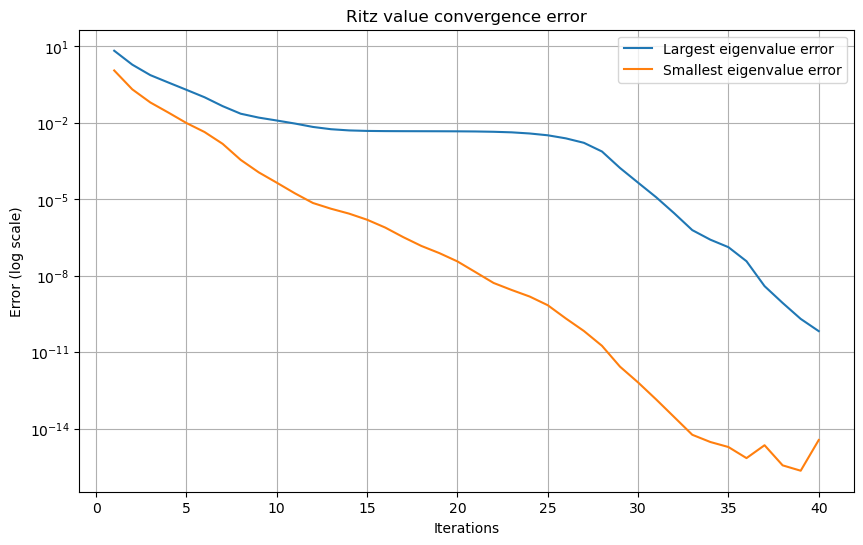

In [74]:
d = 10
n = d**2
nbiter = 40

A = spsp.diags(
    [[4.]*n, [-1]*(n-1), [-1]*(n-1), [-1]*(n-d), [-1]*(n-d)],
    [0, 1, -1, d, -d]
).toarray()

exact_eigvals = np.linalg.eig(A)[0]
exact_eigvals_sorted = np.sort(exact_eigvals)
largest_eigval = exact_eigvals_sorted[-1]
smallest_eigval = exact_eigvals_sorted[0]

eigvals = Lanczos(A, nbiter)

largest_ritz = np.array([eigvals[i, i] for i in range(nbiter)])
smallest_ritz = np.array([eigvals[i, 0] for i in range(nbiter)])

error_max = np.abs(largest_eigval - largest_ritz)
error_min = np.abs(smallest_eigval - smallest_ritz)

plt.figure(figsize=(10, 6))
plt.semilogy(range(1, nbiter+1), error_max, label='Largest eigenvalue error')
plt.semilogy(range(1, nbiter+1), error_min, label='Smallest eigenvalue error')
plt.xlabel('Iterations')
plt.ylabel('Error (log scale)')
plt.title('Ritz value convergence error')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
condition_number = np.abs(largest_eigval / smallest_eigval)
print(f"condition_number: {condition_number}")

condition_number: 93.23038565291226


5. 

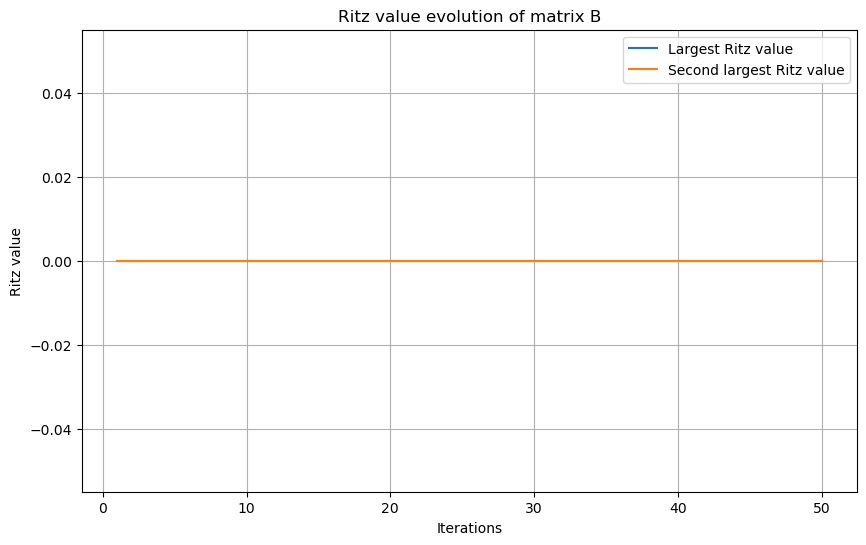

In [76]:
L = np.concatenate((np.arange(0, 2.0, 0.01), [2.0, 2.5, 3.0]))
B = spsp.diags(L, 0, dtype='float64').toarray()

nbiter_B = 50
eigvals_B = Lanczos(B, nbiter_B)

largest_ritz_B = eigvals_B[:, -1]
second_largest_ritz_B = eigvals_B[:, -2]

plt.figure(figsize=(10, 6))
plt.plot(range(1, nbiter_B+1), largest_ritz_B, label='Largest Ritz value')
plt.plot(range(1, nbiter_B+1), second_largest_ritz_B, label='Second largest Ritz value')
plt.xlabel('Iterations')
plt.ylabel('Ritz value')
plt.title('Ritz value evolution of matrix B')
plt.legend()
plt.grid(True)
plt.show()

### Partie 2. (Méthode QR)

6. 

In [77]:
def cgivens(a, b):
    r = np.hypot(a, b)
    c = a / r
    s = -b / r
    return c, s

def facto_QR_hessenberg(A):
    n = A.shape[0]
    Q = np.eye(n)
    R = A.copy()
    for k in range(n - 1):
        a = R[k, k]
        b = R[k + 1, k]
        c, s = cgivens(a, b)

        G = np.array([[c, -s], [s, c]])

        R_k = R[k:k+2, k:]
        R[k:k+2, k:] = G @ R_k

        Q[:, k:k+2] = Q[:, k:k+2] @ G.T
    return Q, np.triu(R)

8. 

In [78]:
def QR_hessenberg(A, max_iter=2000, tol=1e-10):
    n = A.shape[0]
    H = A.copy()
    for i in range(max_iter):
        Q, R = facto_QR_hessenberg(H)
        H = R @ Q

        off_diag = np.abs(np.diag(H, -1))
        if np.all(off_diag < tol):
            break
    eigvals = np.diag(H)
    return eigvals

9. 

In [79]:
n = 5
diagonal = np.random.rand(n)
off_diagonal = np.random.rand(n - 1)
A_sym_tridiag = np.diag(diagonal) + np.diag(off_diagonal, 1) + np.diag(off_diagonal, -1)

eigvals_qr = QR_hessenberg(A_sym_tridiag)

eigvals_exact = np.linalg.eig(A_sym_tridiag)[0]

print("Exact eigenvalues by QR:", np.sort(eigvals_qr))
print("Exact eigenvalues:", np.sort(eigvals_exact))
print("Difference:", np.abs(np.sort(eigvals_qr) - np.sort(eigvals_exact)))

Exact eigenvalues by QR: [-0.7828134   0.28462167  0.4925791   1.39278001  1.6200164 ]
Exact eigenvalues: [-0.7828134   0.28462167  0.4925791   1.39278001  1.6200164 ]
Difference: [4.44089210e-16 4.99600361e-16 8.88178420e-16 1.99840144e-15
 8.88178420e-16]


Les valeurs propres calculées par la méthode QR sont proches des résultats de `np.linalg.eig`.

10. 

In [80]:
def Lanczos_with_QR(A, nbiter):
    n = A.shape[0]
    nbiter = min(nbiter, n)
    eigval = np.zeros((nbiter, nbiter))
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)
    vold = np.zeros(n)
    beta = 0.0
    alphas = []
    betas = []
    for p in range(nbiter):
        v, vold, beta, alpha = iter_Arnoldi_sym(A, v, vold, beta)
        alphas.append(alpha)
        betas.append(beta)

        T_p = np.diag(alphas) + np.diag(betas[:-1], k=1) + np.diag(betas[:-1], k=-1)

        eigvals_Tp = QR_hessenberg(T_p)
        eigvals_Tp_sorted = np.sort(eigvals_Tp)

        eigval[p, :p+1] = eigvals_Tp_sorted
    return eigval

In [81]:
import time

nbiter = min(nbiter, n)

start_time = time.time()
eigvals_qr = Lanczos_with_QR(A, nbiter)
time_qr = time.time() - start_time

start_time = time.time()
eigvals_np = Lanczos(A, nbiter)
time_np = time.time() - start_time

print(f"Computation time using QR method:{time_qr:.4f} s")
print(f"Computation times using numpy.linalg.eig :{time_np:.4f} s")

Computation time using QR method:0.0127 s
Computation times using numpy.linalg.eig :0.0004 s
